In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
# identify variable names and types
m_variables = inspector.get_columns('measurement')
print("Measurement table")
print("-"*15)
for column in m_variables:
    print(column["name"], column["type"])
print("*"*15)
print("*"*15)
s_variables = inspector.get_columns('station')
print("Station table")
print("-"*15)
for column in s_variables:
    print(column["name"], column["type"])

Measurement table
---------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
***************
***************
Station table
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent

'2017-08-23'

Dropping nulls. Total: 209


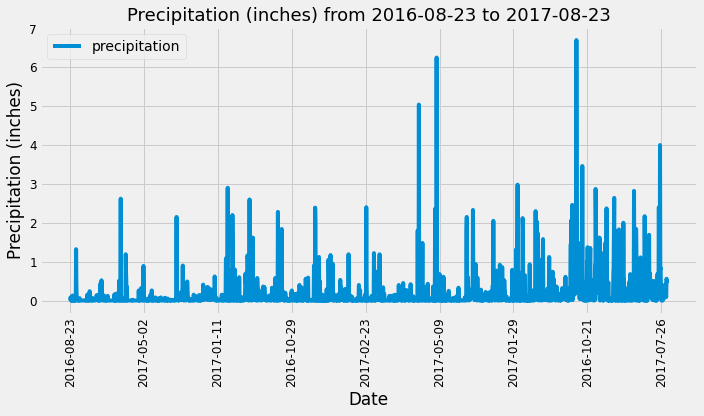

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.  
# make most_recent a string
# Calculate the date one year from the last date in data set.
most_recent_str = (dt.datetime.strptime(most_recent, "%Y-%m-%d")).date()
date_1yrago = most_recent_str - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(measurement.date, measurement.prcp).filter((measurement.date >= date_1yrago))

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df = pd.DataFrame(precip)
precip_df.rename(columns={0: "date", 1: "precipitation"}, inplace=True)
# precip_df.sort_values("date").set_index("date")
precip_df.set_index('date',inplace=True)
precip_df.sort_index()
precip_df.head()

# drop null values
print(f"Dropping nulls. Total: {precip_df['precipitation'].isnull().sum()}")
precip_df.dropna(axis=0, how="any", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(10,6), fontsize=12, rot=90)
plt.title(f"Precipitation (inches) from {date_1yrago} to {most_recent_str}", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# see station table variables again so I don't have to scroll
s_variables = inspector.get_columns('station')
print("Station table")
print("-"*15)
for column in s_variables:
    print(column["name"], column["type"])

Station table
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
print(f"total stations = {total_stations}") 

total stations = 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
                order_by(func.count(measurement.station).desc()).\
                group_by(measurement.station).all()
print("Most Active Stations in descending order")
print("*"*15)
most_active

Most Active Stations in descending order
***************


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# find most active station
most_active_station = most_active[0][0]
# lowest temp
lowest_temp = session.query(func.min(measurement.tobs)).\
                filter(measurement.station == most_active_station).scalar()
# highest temp
highest_temp = session.query(func.max(measurement.tobs)).\
                filter(measurement.station == most_active_station).scalar()
# avg temp
avg_temp = session.query(func.avg(measurement.tobs)).\
                filter(measurement.station == most_active_station).scalar()

print(f"The most active station is {most_active_station}")
print(f"The lowest temperature was {lowest_temp}")
print(f"The highest temperature was {highest_temp}")
print(f"The average temperature was {avg_temp}")

The most active station is USC00519281
The lowest temperature was 54.0
The highest temperature was 85.0
The average temperature was 71.66378066378067


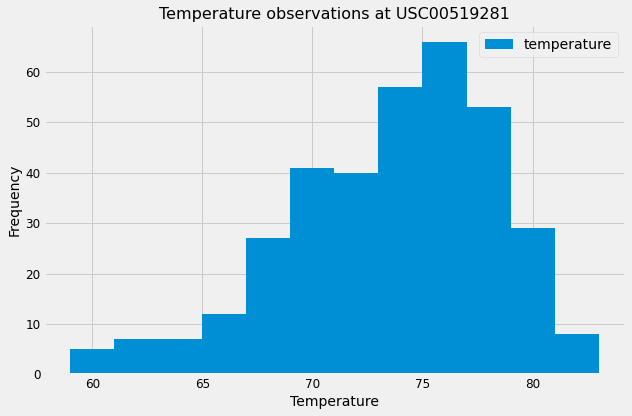

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# create dataframe
most_active_temp = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active_station)\
                                        & (measurement.date >= date_1yrago)).all())

# rename column from 0 to temperature
most_active_temp.rename(columns={0: "temperature"}, inplace=True)
most_active_temp.head()
# plot dataframe in histogram
most_active_temp.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations at {most_active_station}", fontsize=16)
plt.tight_layout()
plt.show()

# Close session

In [17]:
# Close Session
session.close()